A comparision with FairLearn reductions on multi-group adult

In [1]:
import dataset_loader
from oxonfair import FairPredictor
from oxonfair import group_metrics as gm
from oxonfair.utils.performance import evaluate_fairness
import fairlearn.reductions

import xgboost
import pandas as pd
import numpy as np
import fairlearn
import time
import pandas as pd
train_data, val_data, test_data = dataset_loader.adult('race',train_proportion=0.7,test_proportion=0.3)

start=time.perf_counter()
predictor = xgboost.XGBClassifier().fit(X=train_data['data'], y=train_data['target'])
stop=time.perf_counter()
print(stop-start)



0.7094544169999999


array([' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other',
       ' White'], dtype=object)

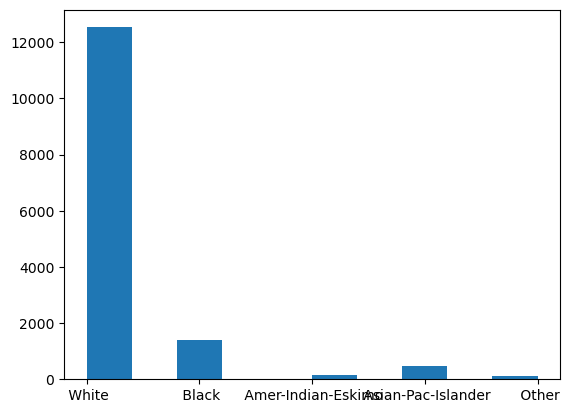

In [2]:
from matplotlib import pyplot as plt
plt.hist(test_data['groups'])
np.unique(test_data['groups'])

In [3]:
anon=pd.DataFrame(np.zeros((3,3)),columns=['Accuracy','Demographic Parity','Time'])
anon=np.zeros((3,4))
fairl=pd.DataFrame(np.zeros((3,3)),columns=['Accuracy','Demographic Parity','Time'])
fairl=np.zeros((3,4))

In [4]:
for i,name in enumerate ((' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', "Other")):
    start=time.perf_counter()
    fpred = FairPredictor(predictor,train_data)
    fpred.fit(gm.accuracy,gm.demographic_parity,0.01)
    stop=time.perf_counter()
    score=fpred.evaluate_fairness(test_data,metrics={'a':gm.accuracy,'b':gm.demographic_parity},verbose=False)
    anon[0,i]=score['updated']['a']#['updated']
    anon[1,i]=score['updated']['b']#['updated']
    anon[2,i]=stop-start
    start=time.perf_counter()
    fair = fairlearn.reductions.ExponentiatedGradient(xgboost.XGBClassifier(),fairlearn.reductions.DemographicParity())
    fair.fit(X=train_data['data'],
         y=train_data['target'],
         sensitive_features=train_data['groups'])
    stop=time.perf_counter()
    score=evaluate_fairness(test_data['target'], fair.predict(test_data['data']), test_data['groups'], metrics={'a':gm.accuracy,'b':gm.demographic_parity},verbose=False)
    fairl[0,i]=score[0]['a']#['updated']
    fairl[1,i]=score[0]['b']#['updated']
    fairl[2,i]=stop-start
    train_data['groups'][train_data['groups']==name]=' Other'
    test_data['groups'][test_data['groups']==name]=' Other'

In [5]:
anon_df=pd.DataFrame(anon.T,columns=['Accuracy','Demographic Parity','Time'])
fairl_df=pd.DataFrame(fairl.T,columns=['Accuracy','Demographic Parity','Time'])


In [9]:
print(pd.concat((anon_df,fairl_df),axis=1).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
 & Accuracy & Demographic Parity & Time & Accuracy & Demographic Parity & Time \\
\midrule
0 & 0.868414 & 0.020884 & 50.576869 & 0.867527 & 0.032869 & 42.506781 \\
1 & 0.867663 & 0.028689 & 0.802240 & 0.868141 & 0.041368 & 27.054427 \\
2 & 0.868073 & 0.008791 & 0.081120 & 0.867049 & 0.015203 & 23.689572 \\
3 & 0.868073 & 0.003674 & 0.055124 & 0.869574 & 0.006705 & 27.069056 \\
\bottomrule
\end{tabular}

